# Titanic Disaster Analysis

<img src="https://www.slate.fr/sites/default/files/styles/1060x523/public/000_arp1718951.jpg" width="1000" height="500">

The Titanic was a British passenger liner that sank in the North Atlantic Ocean on April 15, 1912, after colliding with an iceberg during her maiden voyage from Southampton to New York City. Of the 2,224 passengers and crew on board, only 712 survived. The disaster was one of the deadliest peacetime maritime disasters in history, and it led to significant improvements in maritime safety regulations, including the requirement for ships to carry enough lifeboats for all passengers and crew.

In [134]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns


Let's import the dataset

In [2]:
train_tit = pd.read_csv('/Users/stratospheric/Documents/Titanic Competition/titanic/train.csv')
train_tit.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_tit = pd.read_csv('/Users/stratospheric/Documents/Titanic Competition/titanic/test.csv')
test_tit.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
print('Shape training set :',train_tit.shape)
print('Shape testing set:',test_tit.shape)

Shape training set : (891, 12)
Shape testing set: (418, 11)


## Training Set Analysis

In [5]:
train_tit.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It seems some data is missing on Age and cabin, but how bad it is ?

In [6]:
train_tit.isnull().sum()/train_tit.shape[0]*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

77% of Cabin data is missing, Cabin info may be a valuable information,because as we know the bottom of the boat sink first, so determine on what deck was passengers can be precious for the prediction. I will try to work around it.

But to be sure, let's see if the Deck had real impact on survival rate.


<img src="https://upload.wikimedia.org/wikipedia/commons/0/0d/Olympic_%26_Titanic_cutaway_diagram.png" width="500" height="500">

## Deck Pre Analysis

In [7]:
train_tit['Cabin'] = train_tit['Cabin'].astype('str')

deck = []
for cabin in train_tit['Cabin'] :
    if cabin[0] != 'n' :
        deck.append(cabin[0])
    else :
        deck.append(None)

The first letter of the cabin determine the deck, so I extract the first letter to create a new column called deck.

In [8]:
train_tit['Deck'] = deck
train_tit.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,nan,S,None
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,nan,S,None
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,nan,S,None


In [9]:
train_tit['Deck'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Deck, dtype: int64

As we see, there is 8 decks.

I replace letter by number to be able to plot the relationship.

In [10]:
deck_dum = train_tit
deck_dum['Deck'].replace('A', 1, inplace=True)
deck_dum['Deck'].replace('B', 2, inplace=True)
deck_dum['Deck'].replace('C', 3, inplace=True)
deck_dum['Deck'].replace('D', 4, inplace=True)
deck_dum['Deck'].replace('E', 5, inplace=True)
deck_dum['Deck'].replace('F', 6, inplace=True)
deck_dum['Deck'].replace('G', 7, inplace=True)
deck_dum['Deck'].replace('T', 8, inplace=True)

deck_dum = deck_dum.dropna(subset=['Deck'])


In [11]:
deck_dum.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,5.0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,7.0
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,3.0


<Axes: xlabel='Deck', ylabel='Survived'>

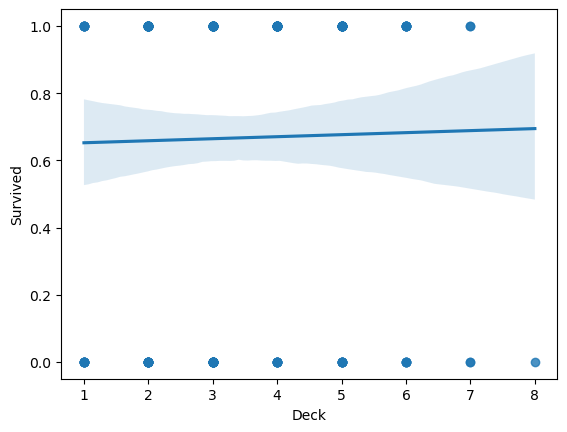

In [12]:
sns.regplot(deck_dum, x='Deck', y='Survived')

### Insight

After analyzing the plot, it appears that there is no significant relationship between the Deck and Survival Rate. 

Therefore, it can be concluded that determining the deck of passengers would not improve the accuracy of our analysis. As a result, I have decided to delete the `Cabin` and `Deck`columns from the dataset, as they are no longer needed for our analysis.

In [13]:
train_tit.drop(["Cabin","Deck"],axis=1, inplace=True)
train_tit.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

## Statiscal Analysis

For now let's explore a little

In [ ]:
train_tit.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Our dataset includes a survival rate of 38%. 

The average age of the passengers was 30 years old, which is relatively young. 

The oldest male passenger was 80 years old. 

The highest ticket fare was 512 (currency unknown), but after some research it seems that the currency is £.

Interestingly, 38% of the survivors were either parents or children. 

Additionally, 52% of the passengers had no siblings or spouses, indicating that some individuals were travelling alone. 

It should be noted that the dataset only contains 891 entries, despite there being 2224 passengers onboard the Titanic.


Who are those passengers who pay the highest price for this trip ?

In [66]:
train_tit.loc[train_tit['Fare'] > 512, 'Name']


258                      Ward, Miss. Anna
679    Cardeza, Mr. Thomas Drake Martinez
737                Lesurer, Mr. Gustave J
Name: Name, dtype: object

Did they survived ?

In [68]:
train_tit.loc[train_tit['Fare'] > 512, 'Survived']


258    1
679    1
737    1
Name: Survived, dtype: int64

Yes, all of them.
It opens a question : People who paid higher have a better chance to survive ?

## Class and Price

We know the Class and the Price of the Ticket, I assume the more the class is cheap, the more the fare is low.

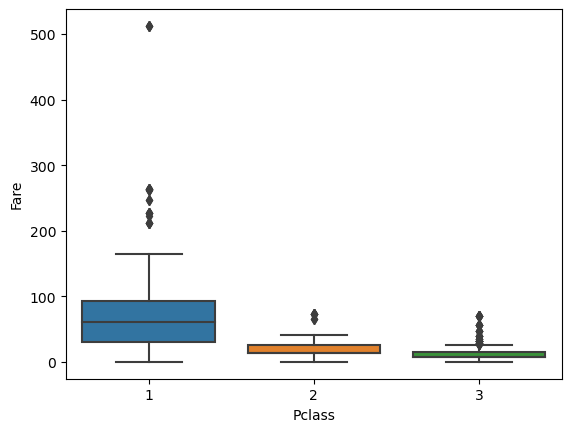

,Pclass,Fare
Pclass,1.0000,-0.5495
Fare,-0.5495,1.0000


In [ ]:

sns.boxplot(train_tit, x='Pclass', y='Fare')
plt.show()
train_tit[['Pclass','Fare']].corr()

The boxplot shows a clear relationship between the price and the class of the tickets, as we might expect. However, what is interesting is that the range of prices for first class tickets is much wider than the range for other classes.

Moreover, we observed some outliers in the third class, where passengers paid prices as high as those in the first class. This is a surprising finding that warrants further investigation.

It ask a question : The more they paid, the more they survived ?

,Survived,Fare
Survived,1.000000,0.257307
Fare,0.257307,1.000000


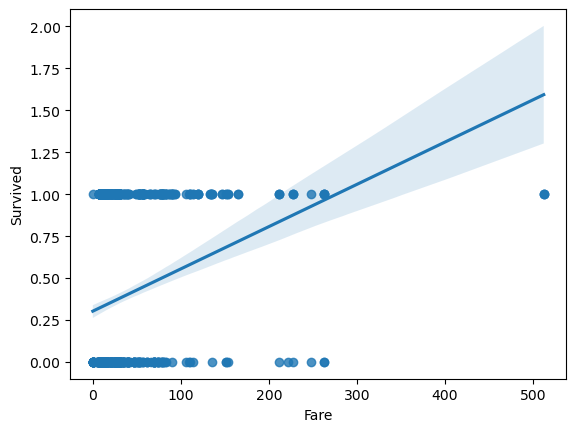

In [213]:
sns.regplot(train_tit, x='Fare', y='Survived')
train_tit[['Survived','Fare']].corr()

### Insight

In response to the question of whether the more passengers pay, the more likely they are to survive, the answer is somewhat complex. 

There does appear to be a relationship between fare and survival, but the strength of this relationship is not consistent across all values of the fare.

As the fare increases, the variance also increases, which indicates that there is less correlation between the fare and survival at higher values. However, for fares between 0 and 100£, the correlation appears to be quite strong.

If we look closer, we can see that the variance increase when we move beyond the 3rd quartile of the first class fare. It makes sense.

So passenger class seems more important than the price of the ticket.

## Class analysis

In this section, we will investigate the relationship between class and survival rate, and then examine the impact of the 'Sex' factor on this relationship.

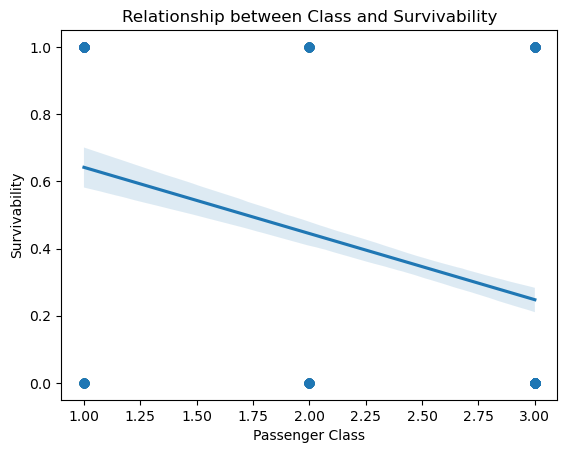

In [75]:
sns.regplot(train_tit, x='Pclass', y='Survived')
plt.title('Relationship between Class and Survivability')
plt.xlabel('Passenger Class')
plt.ylabel('Survivability')
plt.show()

In [256]:
train_tit[['Pclass','Survived']].corr()

,Pclass,Survived
Pclass,1.000000,-0.338481
Survived,-0.338481,1.000000


The answer is clearly, yes.
The better is the class, the better is the chance to survive.

### Gender factor

Let's examine whether gender was a determining factor in surviving the Titanic disaster. 
While the phrase "Women and Children first" was famously used in the movie, we need to investigate whether it holds true in our dataset.

In [77]:
train_tit['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

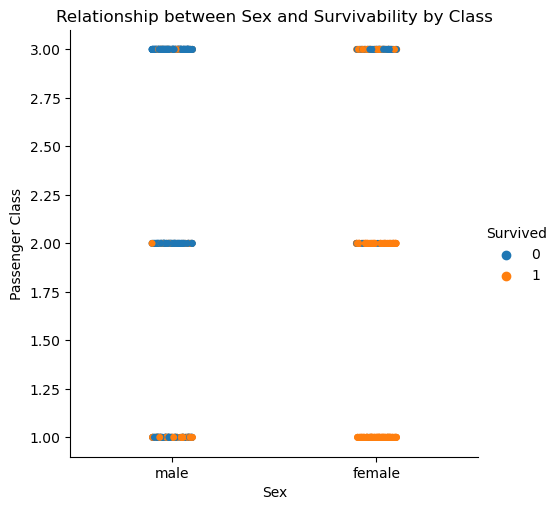

In [83]:
sns.catplot(train_tit, x='Sex', y='Pclass', hue='Survived')
plt.title('Relationship between Sex and Survivability by Class')
plt.xlabel('Sex')
plt.ylabel('Passenger Class')
plt.show()

Wow that's interesting !

Female had a higher survival rate compared to male overall. However, male in first class seems to had a higher survival rate comparable to female in third class.

Let's take a dive into it.

First, I create a dataframe with only female, grouped by class.

In [167]:
women = train_tit[train_tit['Sex'] == 'female']


women_s = women.groupby('Pclass')['Survived'].value_counts().to_frame()
women_s['percent_f'] = women_s['Survived']/women_s['Survived'].sum()*100
women_s['percent_f'] = round(women_s['percent_f'],2)
women_s

Survived  percent_f
Pclass Survived                     
1      1               91      28.98
       0                3       0.96
2      1               70      22.29
       0                6       1.91
3      0               72      22.93
       1               72      22.93

Then I do the same for male.

In [191]:
men = train_tit[train_tit['Sex'] == 'male']

men_s = men.groupby('Pclass')['Survived'].value_counts().to_frame()

men_s['percent_m'] = men_s['Survived']/men_s['Survived'].sum()*100
men_s['percent_m'] = round(men_s['percent_m'],2)
men_s

Survived  percent_m
Pclass Survived                     
1      0               77      13.34
       1               45       7.80
2      0               91      15.77
       1               17       2.95
3      0              300      51.99
       1               47       8.15

In [193]:
men_s.rename(columns={'Survived':'Survived_male'},inplace=True)

In [170]:
women_s.rename(columns={'Survived':'Survived_female'},inplace=True)




I join the two dataframe male and female.

In [207]:
gender_df = pd.concat([men_s[['Survived_male', 'percent_m']], women_s[['Survived_female', 'percent_f']]], axis=1)
gender_df

Survived_male  percent_m  Survived_female  percent_f
Pclass Survived                                                      
1      0                    77      13.34                3       0.96
       1                    45       7.80               91      28.98
2      0                    91      15.77                6       1.91
       1                    17       2.95               70      22.29
3      0                   300      51.99               72      22.93
       1                    47       8.15               72      22.93

Next I want to know the total passengers for each class.

In [208]:
class_s = gender_df.groupby('Pclass').sum().reset_index()
class_s

,Pclass,Survived_male,percent_m,Survived_female,percent_f
0,1,122,21.14,94,29.94
1,2,108,18.72,76,24.20
2,3,347,60.14,144,45.86


They were 347 males passengers in third class, (60% of the whole) and 144 females passengers (45% of the whole).

Then, I create a dataframe with only survivors (by class)

In [210]:
#gender_df = gender_df.reset_index()

In [238]:

survi = gender_df[gender_df['Survived'] == 1].reset_index()
survi

,index,Pclass,Survived,Survived_male,percent_m,Survived_female,percent_f
0,1,1,1,45,7.80,91,28.98
1,3,2,1,17,2.95,70,22.29
2,5,3,1,47,8.15,72,22.93


Let's find, the proportion of survivors by class.

To do this, I divide the survivors calculated in `survi` by the total passengers in each class calculated in `class_s`.

In [244]:
survi['percent_m'] = survi['Survived_male'] / class_s['Survived_male']*100
survi['percent_m'] = round(survi['percent_m'],2)

survi['percent_f'] = survi['Survived_female'] / class_s['Survived_female']*100
survi['percent_f'] = round(survi['percent_f'],2)

survi.head()

,index,Pclass,Survived,Survived_male,percent_m,Survived_female,percent_f
0,1,1,1,45,36.89,91,96.81
1,3,2,1,17,15.74,70,92.11
2,5,3,1,47,13.54,72,50.00


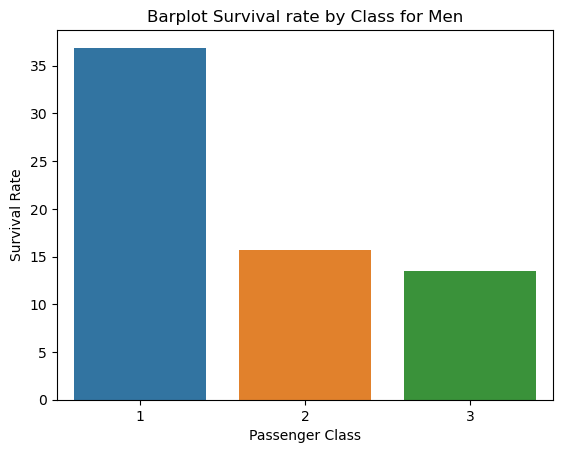

In [250]:
sns.barplot(survi, x='Pclass', y='percent_m')
plt.title('Barplot Survival rate by Class for Men')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

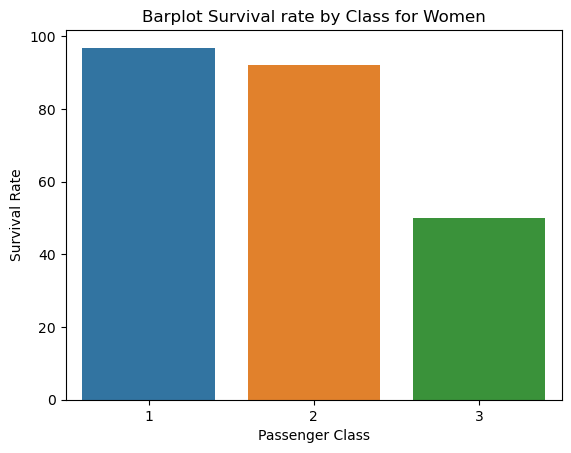

In [251]:
sns.barplot(survi, x='Pclass', y='percent_f')
plt.title('Barplot Survival rate by Class for Women')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

### Insight

As observed, the survival rate of male passengers in the first class was twice as high as the other classes (37%). For female passengers, the survival rate was more balanced between the first and second classes, but twice as low for the third class. 

Overall, gender had a significant impact on the survival rate.

## Age Analysis 

The age of passengers onboard the Titanic played a significant role in their survival rate during the disaster. In this analysis, we will explore the relationship between age and survival, investigating factors such as age distribution, age demographics of survivors, and differences in survival rates between age groups. 

By examining these factors, we aim to gain a deeper understanding of how age influenced the outcome of the Titanic disaster, shedding light on the experiences of different age groups during this tragic event.

array([[<Axes: title={'center': 'Age'}>]], dtype=object)

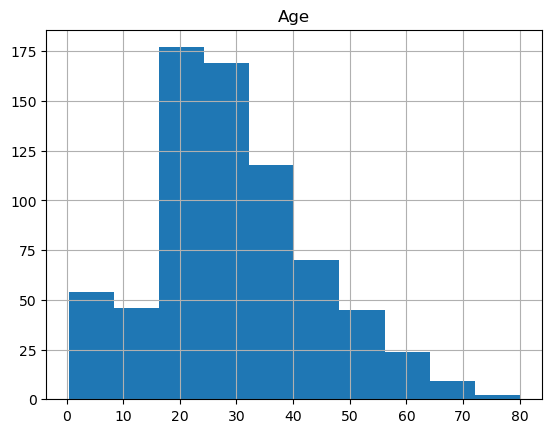

In [26]:
train_tit.hist(column='Age')

,Age,Survived
Age,1.000000,-0.077221
Survived,-0.077221,1.000000


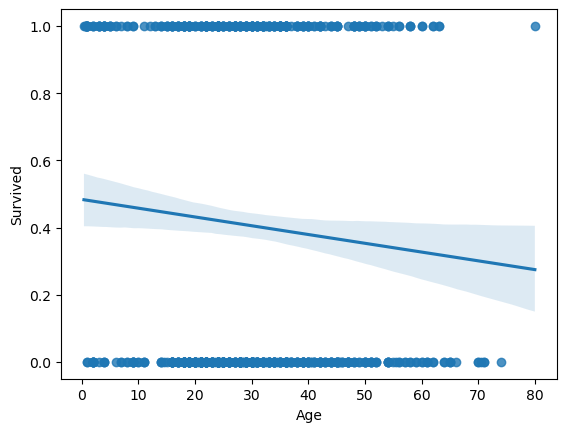

In [255]:
sns.regplot(train_tit, x='Age', y='Survived')

train_tit[['Age','Survived']].corr()

,Age,Fare
Age,1.000000,0.096067
Fare,0.096067,1.000000


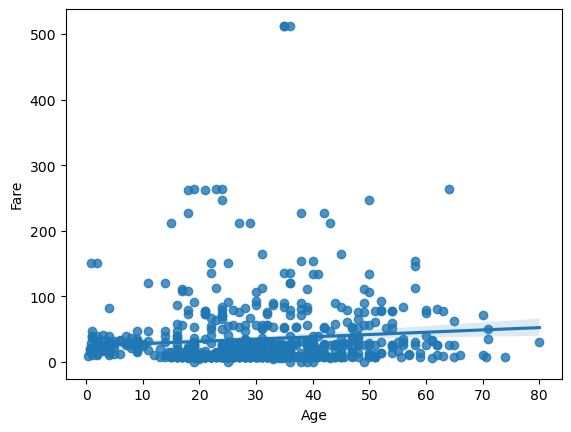

In [259]:
sns.regplot(train_tit, x='Age', y='Fare')
train_tit[['Age','Fare']].corr()

,Age,Pclass
Age,1.000000,-0.369226
Pclass,-0.369226,1.000000


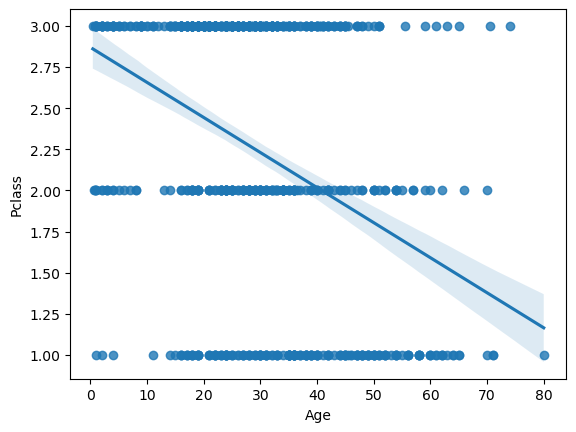

In [260]:
sns.regplot(train_tit, x='Age', y='Pclass')
train_tit[['Age','Pclass']].corr()

There is a moderate relationship between `Age` and `Class`. The older a passenger was, the better was the class.

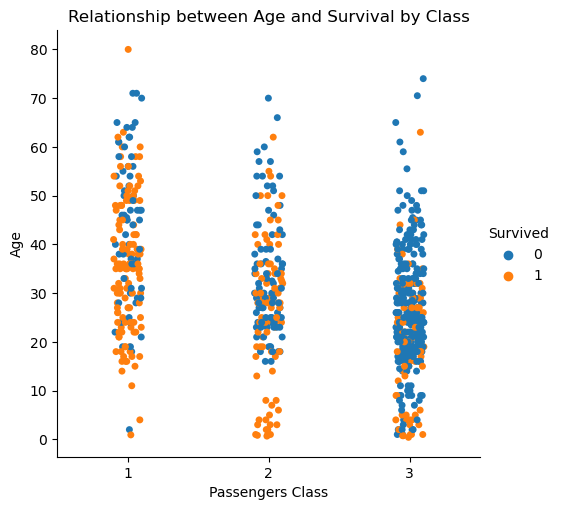

In [11]:
sns.catplot(train_tit, x='Pclass', y='Age',hue='Survived')
plt.title('Relationship between Age and Survival by Class')
plt.xlabel('Passengers Class')
plt.show()


Passengers who were children under the age of 10 and traveling in the 2nd and 3rd class had a higher survival rate compared to older passengers. Additionally, the 1st class had fewer children on board.

In [16]:
def categorize_age(age):
    if age <= 12:
        return "children"
    elif age <= 19:
        return "teenager"
    elif age <= 59:
        return "adult"
    else:
        return "senior"

train_tit['Age_Cat'] = train_tit['Age'].apply(categorize_age)

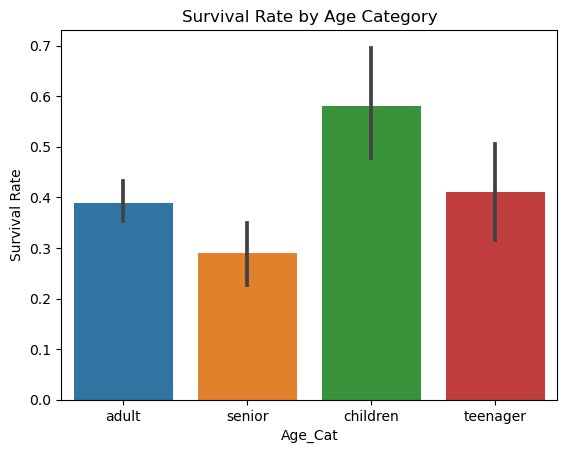

In [17]:
sns.barplot(train_tit, x='Age_Cat', y='Survived')
plt.title('Survival Rate by Age Category')
plt.ylabel('Survival Rate')
plt.show()
          

The survival rate of seniors (over 60 years old) was lower (0.10) compared to that of adults and teenagers.

### Insight

Age had a significant impact on the survival rate, particularly for passengers in the children and senior categories.

In order to create our future model, we replace empty values by the average age.

In [18]:
avg_value = train_tit['Age'].mean().round()
avg_value

30.0

In [19]:
train_tit['Age'].replace(np.nan, avg_value, inplace=True)

In [20]:
train_tit['Age'].isnull().sum()

0

## Sibling Analysis

In the following analysis, we will investigate whether parents with their children or spouses survived or perished together. But also examing if passengers with children had a better survival rate.

In [21]:
train_tit.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Age_Cat'],
      dtype='object')

In [22]:
names = []

for name in train_tit['Name'] :
    name = name.split(",")[0]
    names.append(name)
    
    
sib_df = train_tit.loc[:, ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Survived','Age_Cat']]
sib_df['f_name'] = names

sib_df.head()



,Pclass,Name,Sex,Age,SibSp,Parch,Survived,Age_Cat,f_name
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,0,adult,Braund
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,1,adult,Cumings
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,1,adult,Heikkinen
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,1,adult,Futrelle
4,3,"Allen, Mr. William Henry",male,35.0,0,0,0,adult,Allen


Given that children had a much higher chance of survival, we excluded them from this analysis to avoid bias. 
However, parents were included in the analysis.

In [28]:
sib_sib = sib_df[(sib_df['SibSp'] == 1) & (sib_df['Parch'] == 0) & (sib_df['Age_Cat'] != 'children')]
sib_par = sib_df[(sib_df['Parch'] == 1) & (sib_df['Age_Cat'] != 'children')]

In [29]:
print('Sibling Survival Rate',round(sib_sib['Survived'].mean(),2))
print('Parents Survival Rate',round(sib_par['Survived'].mean(),2))

Sibling Survival Rate 0.52
Parents Survival Rate 0.51


In [30]:
no_sib = sib_df[(sib_df['SibSp'] == 0) & (sib_df['Parch'] == 0)]


In [31]:
print('No Sibling or Children Survival Rate',round(no_sib['Survived'].mean(),2))

No Sibling or Children Survival Rate 0.3


### Insight 

Our analysis suggests that passengers who were accompanied by their children or spouse were more likely to survive than those who traveled alone.

However, parents did not have a significantly higher chance of survival compared than passengers without children.

## Family size

In [70]:
fam_count = sib_df.groupby('f_name').size().to_frame().reset_index()

In [50]:
fam_sur = sib_df.groupby('f_name')['Survived'].mean().reset_index()
fam_sur.head()

,f_name,Survived
0,Abbing,0.0
1,Abbott,0.5
2,Abelson,0.5
3,Adahl,0.0
4,Adams,0.0


In [66]:
fam_sur['count'] = fam_count[0]
fam_sur.head()

,f_name,Survived,count
0,Abbing,0.0,1
1,Abbott,0.5,2
2,Abelson,0.5,2
3,Adahl,0.0,1
4,Adams,0.0,1


(667, 3)

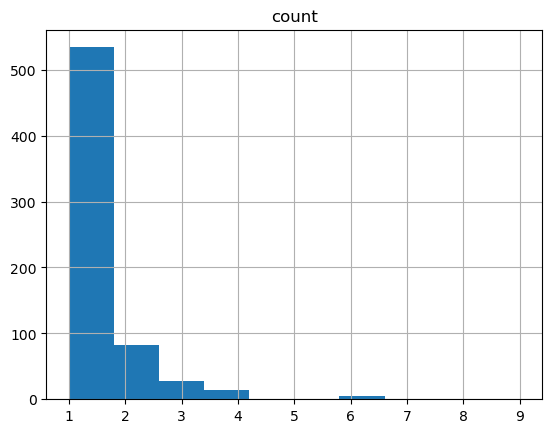

In [72]:
fam_sur.hist(column='count')
fam_sur.shape

It seems we have a problem here. I expected to see mostly family size of 2 but there is a stunning majority of "alone passenger". What does it means ?

I think grouping family by last name is not an appropriate method here to determine family, but before close the case, let's investigate.



I know that "Fortune, Mr. Charles Alexander" had 3 `Sibsp` and 2 `Parch`. Let's see the count value for the Fortune family.

In [83]:
fam_sur.loc[fam_sur['f_name'] == 'Fortune', 'count']

189    4
Name: count, dtype: int64

Someone is missing, the value should be 5 but it's ok.

Another method to see if it works it's to use our previous dataframe `No_sib` who contains passengers with a 0 `Sibsp` and 0 `Parch`

In [86]:
print('Number of passengers without family onboard : ',no_sib.shape[0])

Number of passengers without family onboard :  537


It matches with our histogram ! It means that's not the method who doesn’t work, but the nature of the dataset to included alone passengers.

In [96]:
size = fam_sur['count'].value_counts().to_frame()
proportion = []

for i in size['count']:
    x = i/fam_sur.shape[0]
    proportion.append(x)
    print(x)


0.800599700149925
0.12443778110944528
0.041979010494752625
0.020989505247376312
0.0074962518740629685
0.0014992503748125937
0.0014992503748125937
0.0014992503748125937


In [126]:
size['percent'] = proportion
size['percent'] = size['percent'].round(2)*100

#size = size.reset_index()
#size.drop('level_0', axis=1, inplace=True)
size

,index,count,percent
0,1,534,80.0
1,2,83,12.0
2,3,28,4.0
3,4,14,2.0
4,6,5,1.0
5,9,1,0.0
6,5,1,0.0
7,7,1,0.0


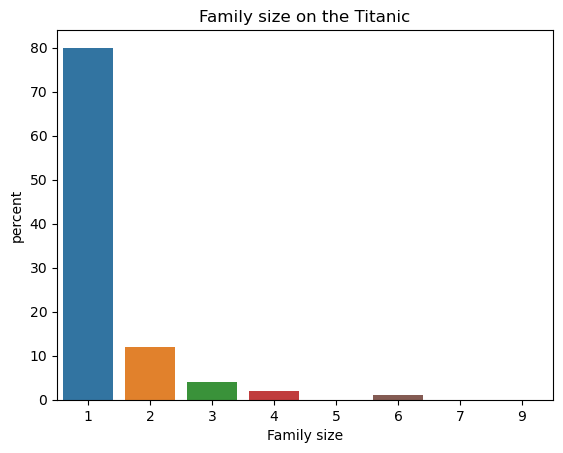

In [116]:
sns.barplot(size, x='index', y='percent')
plt.title('Family size on the Titanic')
plt.xlabel('Family size')
plt.show()

<Axes: xlabel='count', ylabel='Survived'>

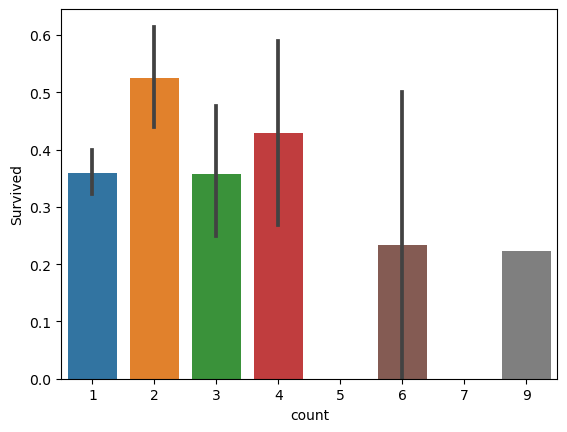

In [117]:
sns.barplot(fam_sur, x='count', y='Survived')

### Insight

Upon analysis of the Titanic dataset, we observed that 80% of the passengers traveled alone. 

Further analysis on the influence of family size revealed that passengers with families of size 2 and 4 had a higher survival rate compared to other family sizes. 

However, due to the relatively small sample sizes for these groups (excluding the alone passengers), it is difficult to make definitive conclusions.



## Ports & Embarkation

The Titanic had three primary ports of embarkation for its passengers: Cherbourg, Queenstown, and Southampton. 

The location of embarkation may have played a role in the survival rate of passengers during the disaster, as different embarkation locations may have different demographics and socioeconomic statuses. 

In this analysis, we will explore the relationship between embarkation location and survival rate, investigating factors such as passenger demographics, ticket class, and other variables that may have influenced the likelihood of survival. 

By examining these factors, we aim to gain a deeper understanding of how embarkation location may have impacted the outcome of the Titanic disaster, shedding light on the experiences of passengers from different parts of the world who embarked on the ill-fated voyage.

Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [114]:
train_tit['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [128]:

embarked = train_tit.groupby('Embarked')['Survived'].mean().reset_index()

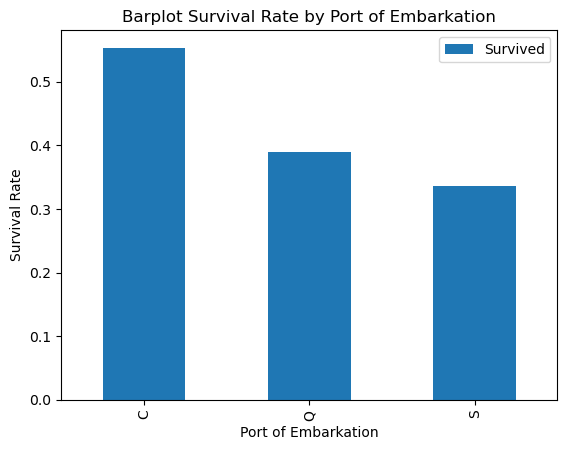

In [132]:
embarked.plot(kind='bar', x='Embarked')
plt.xlabel('Port of Embarkation')
plt.ylabel('Survival Rate')
plt.title('Barplot Survival Rate by Port of Embarkation')

plt.show()

Passengers who boarded at Cherbourg had a higher survival rate. It is unclear why this was the case; it could be due to their socioeconomic status, cabin location, or some other factor.

In [136]:
embarked_class = train_tit.groupby(['Embarked', 'Pclass']).size().unstack()
embarked_class

Pclass,1,2,3
Embarked,,,
C,85,17,66
Q,2,3,72
S,127,164,353


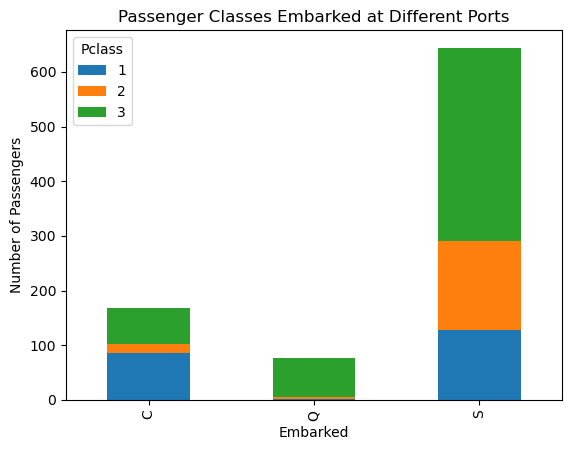

In [137]:
ax = embarked_class.plot(kind='bar', stacked=True)

# set the axis labels and title
ax.set_xlabel('Embarked')
ax.set_ylabel('Number of Passengers')
ax.set_title('Passenger Classes Embarked at Different Ports')

# display the plot
plt.show()

The data suggest that the socio-economic status of passengers, rather than the port of embarkation, was a determining factor in survival rates. 

For example, Cherbourg had a high proportion of first-class passengers, while Queenstown had none. 

Southampton had a similar number of first-class passengers as Cherbourg, but also a large number of third and second-class passengers.

In total, there were 110 first-class passengers out of the 644 who embarked at Southampton  (which included around 60% of third-class passengers).

It probably explain why Cherbourg passengers had a better survival rate than Southampton.

## EDA Conclusion

Through our analysis of the data, we have identified several variables that are most significant in predicting survival rate. These variables include:

- `Pclass`: Passengers in the 1st Class had a higher survival rate, particularly among males.
- `Sex` : Female passengers had a significantly higher chance of survival.
- `Age` : Children under 12 years old had a better chance of survival.
- `Parch` and `Sibsp`: Passengers who had family on board had a higher chance of survival compared to those who traveled alone.

In [131]:
#Exporting the post analysis csv
train_tit.to_csv('train_tit_ok.csv')